# Finalterm

SEOYEON CHOI  
2022-12-13

> 기말고사

In [2]:
import torch 
from fastai.text.all import *

## `1`. COVID19 tweets $\to$ 텍스트생성 (30점)

아래의 코드를 이용하여 자료를 다운로드 하라.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/STML2022/main/posts/Corona_NLP_train.csv',encoding="ISO-8859-1")
df

41157 rows × 6 columns

`(1)` `TextDataLoaders.from_df`을 이용하여 dls오브젝트를 만들어라.

-   text_col=‘OriginalTweet’ 로 설정
-   is_lm=True 로 설정
-   seq_len=64 로 설정

In [4]:
## 올바르게 dls를 생성하였을 경우 dls.show_batch()의 결과는 아래와 같음. 

In [11]:
dls = TextDataLoaders.from_df(df,is_lm=True,seq_len=64,text_col='OriginalTweet')

In [12]:
dls.show_batch()

`(2)` language_model_learner를 이용하여 오브젝트를 생성하라.
`lrnr.fine_tune(3,1e-1)`을 이용하여 학습하라.

-   arch= AWD_LSTM 이용
-   metrics = \[accuracy,perplexity\]

In [13]:
lrnr = language_model_learner(dls, arch= AWD_LSTM, metrics=[accuracy,perplexity] )

In [14]:
lrnr.fine_tune(3,1e-1)

`(3)` “the price of” 이후에 이어질 단어들을 생성하라. (`n_words=20` 으로
설정할 것)

In [94]:
## 생성예시

'the price of stuff increases in other states as a result of the # coronavirus pandemic . So it makes alternatives .'

In [15]:
lrnr.predict('the price of', n_words=20) 

'the price of what we need is on Check out some Facebook websites Live with you and adapt to'

## `2`. COVID19 tweets $\to$ 분류 (30점)

아래의 코드를 이용하여 자료를 다운로드 하라.

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/STML2022/main/posts/Corona_NLP_train.csv',encoding="ISO-8859-1")
df

41157 rows × 6 columns

`(1)` `TextDataLoaders.from_df`을 이용하여 dls오브젝트를 만들어라.

-   text_col=’OriginalTweet’로 설정
-   label_col=’Sentiment’로 설정
-   seq_len=64 로 설정

In [95]:
## 올바르게 dls를 생성하였을 경우 dls.show_batch()의 결과는 아래와 같음. 

In [22]:
dls = TextDataLoaders.from_df(df,text_col='OriginalTweet',label_col='Sentiment',seq_len=64)

In [23]:
dls.show_batch()

`(2)` text_classifier_learner를 이용하여 오브젝트를 생성하라.
`lrnr.fine_tune(5,1e-2)`을 이용하여 학습하라.

-   arch= AWD_LSTM 이용
-   metrics = accuracy 이용

In [24]:
lrnr = text_classifier_learner(dls,AWD_LSTM,metrics=accuracy).to_fp16()

In [25]:
lrnr.fine_tune(5,1e-2)

`(3)` 아래의 텍스트에 대한 분류결과를 확인하라.

-   “the government’s approach to the pendemic has been a complete
    disaster”
-   “the new vaccines hold the promise of a quick return to economic
    growth”

**hint** “the government’s approach to the pendemic has been a complete
disaster” 에 대하여서는 부정으로, “the new vaccines hold the promise of
a quick return to economic growth”에 대하여서는 긍정으로 예측되어야
적절하다.

negative

In [26]:
lrnr.predict("the government's approach to the pendemic has been a complete disaster") 

('Extremely Negative',
 tensor(0),
 tensor([8.7544e-01, 3.0173e-06, 1.2416e-01, 7.9043e-05, 3.0868e-04]))

positive

In [27]:
lrnr.predict("the new vaccines hold the promise of a quick return to economic growth") 

('Extremely Positive',
 tensor(1),
 tensor([1.2628e-06, 9.2473e-01, 5.2453e-05, 4.5041e-05, 7.5169e-02]))

## `3`. human numbers 5 (40점)

아래와 같은 데이터가 있다고 하자.

In [28]:
txt = (['one',',','two',',','three',',','four',',','five',',']*100)[:-1]
mapping = {',':0, 'one':1, 'two':2, 'three':3, 'four':4, 'five':5} 
txt_x = txt[:-1]
txt_y = txt[1:] 

In [29]:
txt_x[:5], txt_y[:5]

(['one', ',', 'two', ',', 'three'], [',', 'two', ',', 'three', ','])

In [59]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

In [60]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float().to("cuda:0")
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float().to("cuda:0")

In [61]:
x[:5],y[:5]

(tensor([[0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]], device='cuda:0'),
 tensor([[1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0.]], device='cuda:0'))

`(1)` `torch.nn.RNNCell()`을 이용하여 다음단어를 예측하는 신경망을
설계하고 학습하라.

In [120]:
torch.manual_seed(12345)
rnncell=torch.nn.RNNCell(6,20).to("cuda:0")
linr = torch.nn.Linear(20,6).to("cuda:0")

In [121]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(linr.parameters()))

In [122]:
T = len(x) 
for epoc in range(500): 
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,20).to("cuda:0") 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht) 
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [123]:
_water = torch.zeros(1,20).to("cuda:0") 
hidden[[0]] = rnncell(x[[0]],_water)
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [124]:
yhat = soft(linr(hidden))

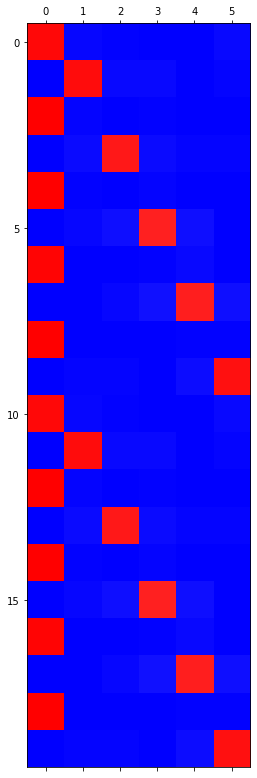

In [125]:
plt.matshow(yhat[-20:].data.to("cpu"),cmap='bwr')

`(2)` `torch.nn.RNN()`을 이용하여 다음단어를 예측하는 신경망을 설계하고
학습하라.

In [151]:
torch.manual_seed(12345)
rnn = torch.nn.RNN(6,20).to("cuda:0")
linr=torch.nn.Linear(20,6).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(linr.parameters()))

In [152]:
_water = torch.zeros(1,20).to("cuda:0")
for epoc in range(8000):
    ## 1 
    hidden,hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [153]:
yhat = soft(output)

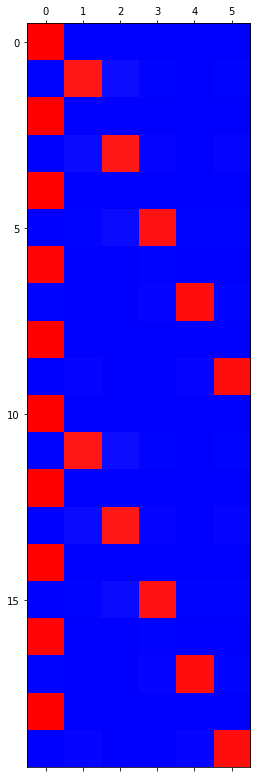

In [154]:
plt.matshow(yhat.data[-20:].to("cpu"),cmap='bwr')

`(3)` `torch.nn.LSTMCell()`을 이용하여 다음단어를 예측하는 신경망을
설계하고 학습하라.

In [236]:
torch.manual_seed(12345) 
lstmcell = torch.nn.LSTMCell(6,4).to("cuda:0") 
linr = torch.nn.Linear(4,6).to("cuda:0") 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(linr.parameters()),lr=0.1)

In [237]:
for epoc in range(5000):
    ## 1
    hidden = []
    ht = torch.zeros(4).to("cuda:0")
    ct = torch.zeros(4).to("cuda:0")
    for xt,yt in zip(x,y): 
        ht,ct = lstmcell(xt,(ht,ct))
        hidden.append(ht) 
    hidden = torch.stack(hidden)
    output = linr(hidden)
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [238]:
yhat = soft(output)
yhat[:10].to("cpu").detach().numpy().round(3)

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

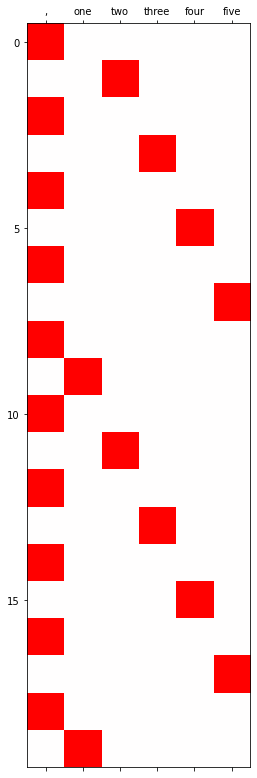

In [242]:
plt.matshow(yhat.to("cpu").data[:20],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(6),labels=[',','one','two','three','four','five']);

`(4)` `torch.nn.LSTM()`을 이용하여 다음단어를 예측하는 신경망을 설계하고
학습하라.

In [243]:
torch.manual_seed(12345) 
lstm = torch.nn.LSTM(6,20).to("cuda:0") 
linr = torch.nn.Linear(20,6).to("cuda:0") 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters())+list(linr.parameters()),lr=0.1)

In [244]:
for epoc in range(5000):
    ## 1 
    hidden, (hT,cT) =lstm(x)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()     

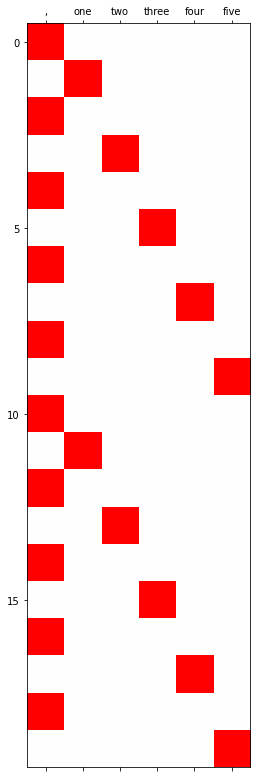

In [245]:
plt.matshow(soft(output).data[-20:].to("cpu"),cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(6),labels=[',','one','two','three','four','five']);

> 참고:
> <https://guebin.github.io/DL2022/posts/2022-11-29-13wk-2-final.html>
> 의 1번풀이를 참고하세요

# ref

https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification